A tarefa a seguir é feita para a disciplina '*PMR3508.2022 - Aprendizado de Máquina e Reconhecimento de Padrões*'. A mesma tem como objetivo trabalhar diretamente com os dados da *Adult Dataset* (ou Base Adult, em portugês). Essa base de dados se trata de um agrupamento de informações do censo estadunidense de 1994, e pode ser utilizada para, no caso a ser estudado, gerar previsões referentes ao rótulo '*income*', ou seja, a renda dos perfis analisados, compostos pelas demais características.
   
Especificamente, para esta tarefa, a ideia é fornecer uma análise suscinta dos dados disponíveis, assim como aplicar um classificador da forma KNN (K-Nearest Neighbors) na mesma, assim obtendo resultados quantitativos apropriados e capazes de fornecer previsões. Para isso, há dois arquivos iniciais para serem trabalhados ao longo do programa: '*train_data.csv*', que contém os dados da Adult Dataset que serão utilizados para treino e validação uma vez que possuem os valores de '*income*'; e '*test_data.csv*', que contém os perfis sem a informação '*income*', e que portanto trata-se do objetivo final preencher essa informação por meio de predições realizadas pelo classificador. 
   
   
Inicialmente, devem ser importadas as livrarias que serão utilizadas pelo código:

In [1]:
#Importando livrarias e algumas de suas funções a serem utilizadas
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing
LE = preprocessing.LabelEncoder()

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

Em seguida, são criadas algumas funções diversas, com o intuito de simplificar o código.
Dentre elas estão as seguintes, acompanhadas por explicações suscintas, assim como as hipóteses que justificam criação e execução:

* A função **tabela** permite rapidamente acessar os arquivos a serem trabalhados, além de identificar os valores faltantes, representados por '?' nos documentos.

In [2]:
###Funcoes a serem utilizadas:
#Acessando a tabela:
def tabela (x):
  return pd.read_csv(x, na_values='?')

* A função **cat_var** permite enlistar as variáveis com base em seu tipo (numéricas ou categóricas). Como o nome sugere, as de perfil numérico possuem valores representáveis por algarismos, já as categóricas são identificadas por vocábulos. Separar e listar esses dois grupos se mostra útil futuramente, quando for desejado referenciar as mesmas.
 * No caso de estudo, as variáveis numéricas são: **[Id, age, fnlwgt, education.num, capital.gain, capital.loss, hours.per.week]**.
 * Já as variáveis categóricas são: **[workclass, education, marital.status, occupation, relationship, race, sex, native.country]**. 

In [3]:
#Funcao para listar variaveis
def cat_var(tab, x):
  if x == 0:
    cat = [i for i in tab.columns if tab.dtypes[i] == 'object']
  if x == 1:
    cat = [i for i in tab.columns if (tab.dtypes[i] == 'float64' or tab.dtypes[i] == 'int64')]
  return cat

* Observando os dados, observa-se uma quantia alta de subcategorias referentes aos países de origem dos perfis analisados (native.country). Como as baixas quantidades de amostras na maior parte das subcategorias pode afetar a análise, há interesse em agrupar algumas dessas com base em critérios de semelhança geográficos, sociais, culturais, e econômicos. Para isso, utiliza-se a função **pais_cat**, que realiza tal papel.
 * Como uma observação à parte, vale observar que foi criado um grupo 'Other/Unknown', que inclui países que não se encaixavam bem em outros subgrupos (Iran, India), termos ambíguos (South), e dados faltantes.

In [4]:
#Funcao para melhor agrupar regioes:
def pais_cat(x):
    if x in ['United-States','Mexico', 'Canada']:
        return 'North America'
    elif x in ['India', 'Iran', '?', 'South']:
        return 'Other/Unknown'
    elif x in ['Thailand', 'Laos', 'Vietnam', 'Hong', 'Taiwan', 'China', 'Japan', 'Cambodia', 'Philippines']:
        return 'South/East Asia'
    elif x in ['Jamaica', 'Dominican-Republic', 'Puerto-Rico', 'Outlying-US(Guam-USVI-etc)', 'Trinadad&Tobago', 'Haiti', 'Cuba']:
        return 'Caribbean'
    elif x in ['England', 'Italy', 'France', 'Greece', 'Ireland', 'Portugal', 'Holand-Netherlands', 'Scotland', 'Germany']:
        return 'South/West Europe'
    elif x in ['Nicaragua', 'Honduras', 'Guatemala', 'El-Salvador', 'Ecuador', 'Peru', 'Columbia']:
        return 'Central/South America'
    elif x in ['Poland', 'Yugoslavia', 'Hungary']:
        return 'Central/East Europe'    

* Dentre as características existentes, pode-se inferir a irrelevância de algumas para o caso a ser estudado. A função **drops** permite a remoção das mesmas nas databases trabalhadas.
 * **Id**: Por servir apenas como um identificador posicional e próprio, não se trata de um fator relevante para quaisquer outros dados, sendo assim removível.
 * **fnlwgt**: Se trata de um peso final, utilizado alguns tipos de análises. Idealmente, perfis semelhantes possuem 'fnlwgt' parecidos. Como também se trata de um valor relativamente próprio para cada perfil, opta-se em excluir essa característica.
 * **education**: Se trata da descrição do tipo de educação de cada perfil. Essa coluna pode ser removida pois há a existência da outra característica 'education.num', que, em teoria, fornece a exata mesma informação por meio de valores numéricos associados.

In [5]:
#Funcao para remover parametros desnecessarios ou repetidos:
def drops(x):
  x.drop(columns=['Id', 'fnlwgt', 'education'], inplace=True)

* A função **grafs_e_mudvar** realiza algumas tarefas distintas. 
 * Inicialmente, ela executa as funções anteriores (em ordem de execução: remove as colunas desnecessárias, reagrupamento de países semelhantes, enlista as variáveis).
 * Em seguida, são plotados os gráficos, ilustrando visualmente os dados estudados respectivos em cada categoria. Para os gráficos com variáveis numéricas são utilizados histogramas, e para os com variáveis categóricas são elaborados simples gráficos de contagem (em barra) organizados numericamente.
 * Por fim, feita a plotagem dos gráficos, a função converte as variáveis categóricas em numéricas, associando então um valor para cada subcaracterística distinta.

In [6]:
#Gerar Graficos e transformar variaveis categoricas em numericas:
def grafs_e_mudvar(tab):
  drops(tab)
  
  #Re-rotulando as regioes de origem:
  tab['native.country'] = tab['native.country'].apply(lambda x: pais_cat(x)) #(Funcao necessaria para essa tabela em particular)
  
  #Colocando as variaveis e parametros em listas:
  var_cat = cat_var(tab, 0)
  var_num = cat_var(tab, 1) 
  
  #Plotando os graficos:
  for n in range(len(var_num)):
    sns.displot(tab[var_num[n]])
    plt.title(label=('Figura ' +str(n+1) + ' - ' + str(var_num[n])), loc='center')
    plt.show()
  
  for k in range(len(var_cat)):
    sns.countplot(data=tab, x=var_cat[k], order=tab[var_cat[k]].value_counts().index)
    plt.title(label=('Figura ' +str(k+n+2) + ' - ' + str(var_cat[k])), loc='center')
    plt.xticks(rotation=30, horizontalalignment='right')
    plt.show()
  
  #Substituindo as variaveis categoricas por valores numericos:
  for k in range(len(var_cat)):
    tab[var_cat[k]] = LE.fit_transform(tab[var_cat[k]])

* Por fim, a última função a ser definida é a função **preparacao**, que secciona os arquivos trabalhados, de modo a isolar a coluna 'income' das demais características. Dessa forma, obtém-se as formas adequadas para utilizar das funções importadas nas livrarias de *machine learning*. 

In [7]:

#Funcao para preparacao dos dados de interesse, separa os demais dos de income (o qual queremos analisar)
#observar que ao chamar a função [1] retorna os valores da coluna 'income', e [0] retorna os dos demais.
def preparacao(tab):
  dados = cat_var(tab, 1)
  dados = tab[dados[:-1]]
  
  income = cat_var(tab, 1)
  income = tab[income[-1]]
  return dados, income 

Definidas as funções, resta então executar as mesmas. Inicia-se carregando os arquivos a serem trabalhados, já os definindo de forma prática, e printando os mesmos para verificação básica. 

Em seguida, executa-se as demais funções, já imbutidas na 'grafs_e_mudvar' previamente vista. Obtém-se então os seguintes resultados, primeiramente para o documento da Base Adult que contém informações na íntegra:

In [8]:
tab_adult = tabela('../input/adult-pmr3508/train_data.csv') #Base Adult
tab_prev = tabela('../input/adult-pmr3508/test_data.csv') #Tabela a ser prevista

tab_adult

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,16280,34,Private,204991,Some-college,10,Divorced,Exec-managerial,Own-child,White,Male,0,0,44,United-States,<=50K
1,16281,58,Local-gov,310085,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K
2,16282,25,Private,146117,Some-college,10,Never-married,Machine-op-inspct,Not-in-family,White,Male,0,0,42,United-States,<=50K
3,16283,24,Private,138938,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,16284,57,Self-emp-inc,258883,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,5178,0,60,Hungary,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,48835,42,Private,384236,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,7688,0,40,United-States,>50K
32556,48836,23,Private,129042,HS-grad,9,Never-married,Machine-op-inspct,Unmarried,Black,Female,0,0,40,United-States,<=50K
32557,48837,30,Private,195488,HS-grad,9,Never-married,Priv-house-serv,Own-child,White,Female,0,0,40,Guatemala,<=50K
32558,48838,18,Private,27620,HS-grad,9,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,25,United-States,<=50K


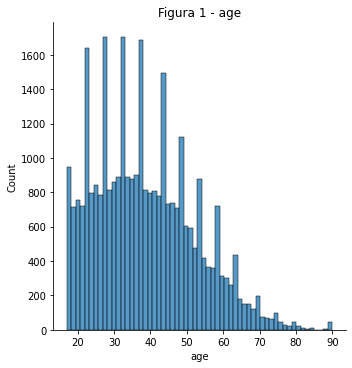

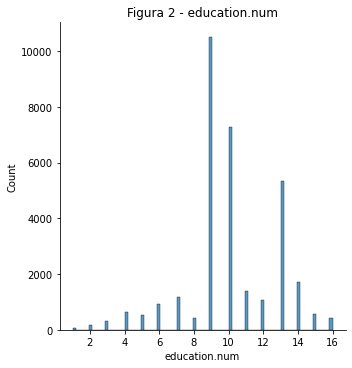

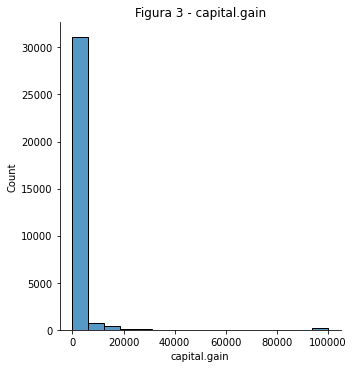

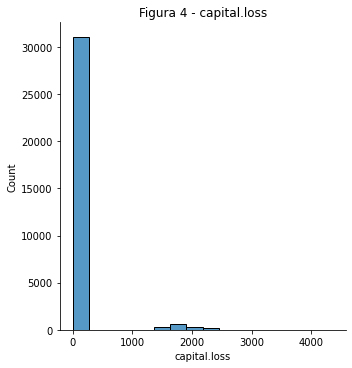

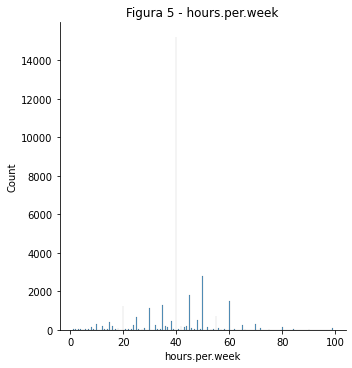

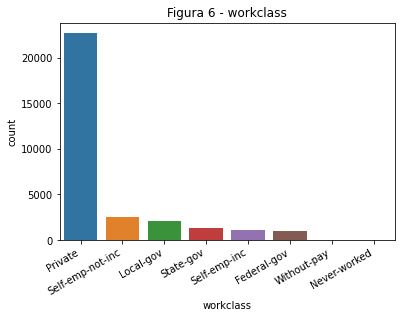

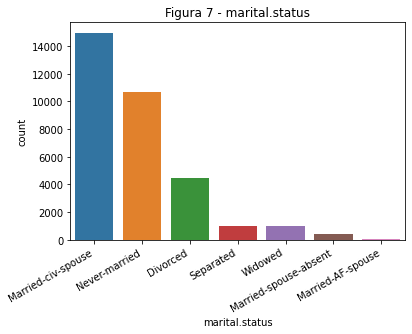

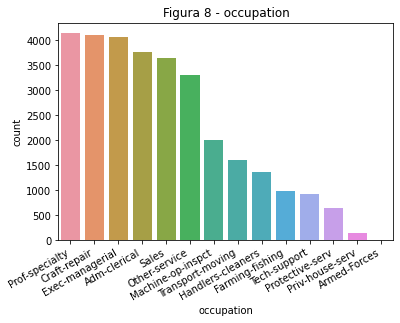

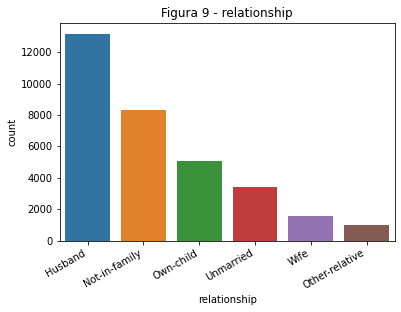

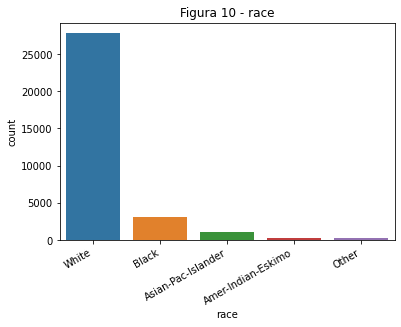

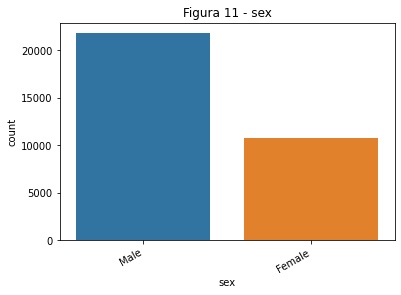

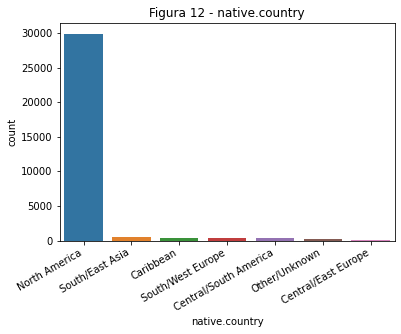

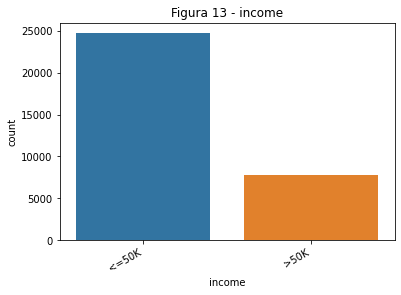

In [9]:
grafs_e_mudvar(tab_adult)

Similarmente, para a base a ser futuramente completada, que não possui ainda os valores de 'income' é possível executar o mesmo procedimento, assim gerando o dataframe e os gráficos respectivos, para comparação direta:

In [10]:
tab_prev

,Id,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0,25,Private,120596,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,44,United-States
1,1,64,State-gov,152537,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States
2,2,31,Private,100135,Masters,14,Divorced,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States
3,3,45,Private,189123,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,United-States
4,4,64,Self-emp-inc,487751,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,16275,40,Private,168113,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States
16276,16276,30,Local-gov,327203,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States
16277,16277,25,Private,116358,HS-grad,9,Never-married,Adm-clerical,Own-child,Asian-Pac-Islander,Male,0,0,40,Philippines
16278,16278,60,Private,39263,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,3325,0,35,United-States


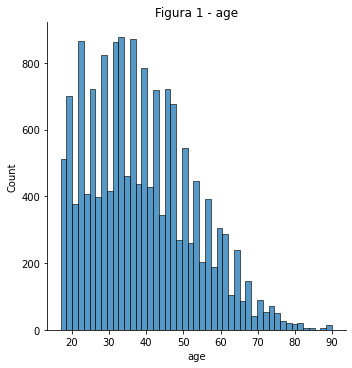

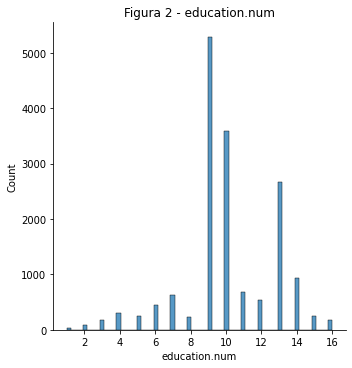

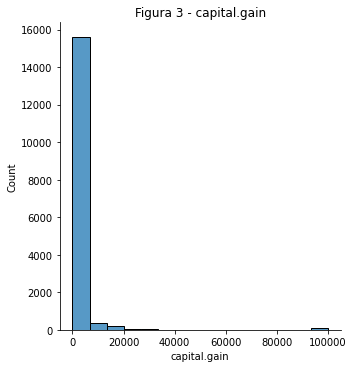

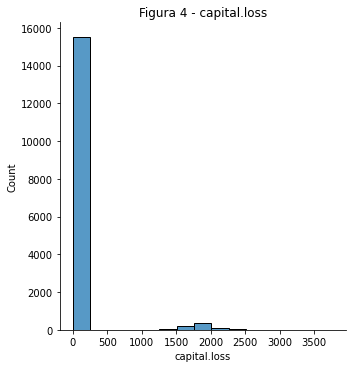

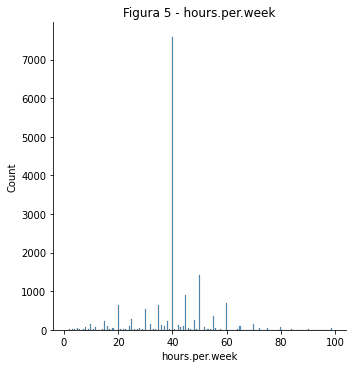

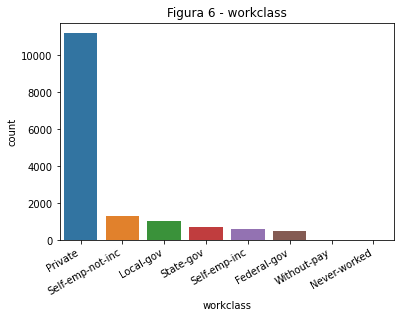

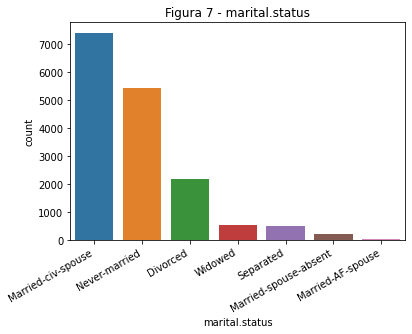

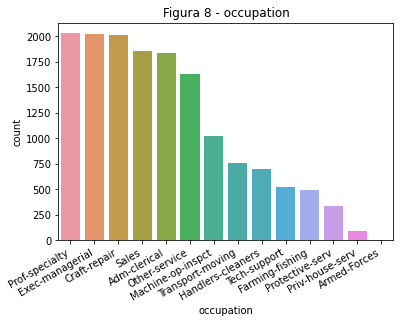

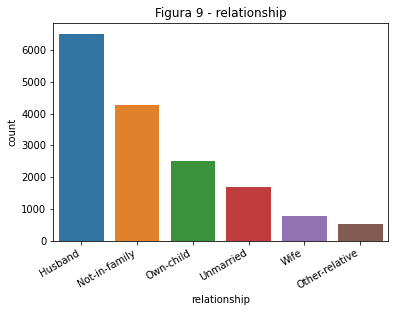

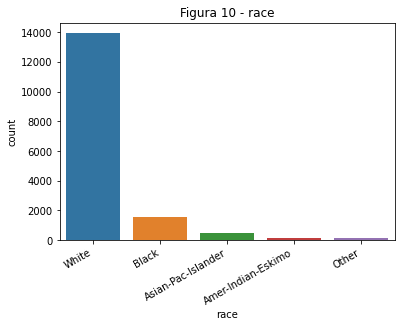

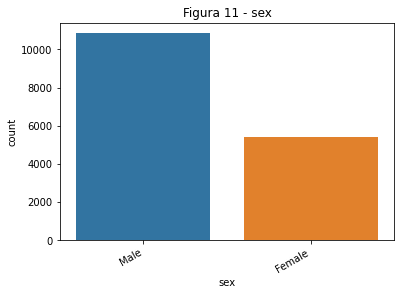

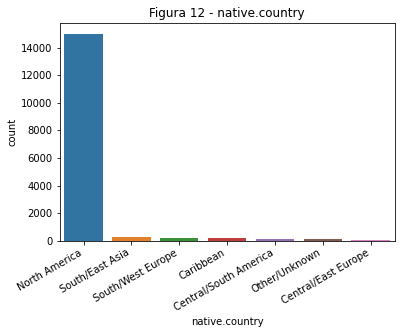

In [11]:
grafs_e_mudvar(tab_prev)

Dos gráficos obtidos é possível fazer algumas observações pertinentes:
* Por análise visual, é possível observar certa frequência anormal em algumas informações. Um exemplo disso são os picos existentes em algumas faixas etárias ('age'), sendo que o esperado seria uma distribuição mais homogênea, sem tanta variação entre idades próximas. Assume-se que essa discrepância tenha ocorrido devido a aproximações de idades desconhecidas durante a coleta dos dados.
* Outro exemplo de dado que chama certa atenção são as colunas referentes ao ganho e perda de capital ('capital.gain' e 'capital.loss', respectivamente), os quais, apesar de possuirem distribuição em certa faixa de valores, se destacam pela grande quantidade de valores acumulados em 0 (zero). Isso é conhecido como 'sparse variables' (ou variáveis esparsas, em tradução livre). Considerou-se remover essas categorias, porém foi ultimamente decidido manter as mesmas, uma vez que admite-se que os valores não-nulos podem ter forte impacto na análise final.
* É possível notar, para algumas características, a concentração em alguns valores. Observa-se um perfil médio composto por homens norte-americanos brancos adultos, trabalhando cerca de 40h semanais no setor privado, atualmente ou nunca casados.

Em seguida, para treinar o classificador (vale relembrar, que neste caso se trata de um KNN), existe a necessidade de utilizar uma base de treino e uma base de validação. Para isso, é possível pegar os dados disponíveis da Base Adult e separá-los, assim dedicando uma parcela para cada finalidade. No código a seguir, adotou-se cerca de 80% da database original para treinar o algoritmo de classificação, e 20% para validação do mesmo.

Feito isso, cada uma das bases a serem utilizadas é processada pela função 'preparacao' já introduzida, assim separando a coluna 'income' das demais informações.

In [12]:
tam_div = round(0.8*len(tab_adult)) #Tamanho da separação
tab_treino=tab_adult.iloc[:tam_div] #Definindo parte a ser utilizada para treino
tab_valid = tab_adult.iloc[tam_div:] #Definindo parte a ser utilizada para verificação

#Dados (não-income)
X_treino = preparacao(tab_treino)[0]
X_valid = preparacao(tab_valid)[0]

#Dados (income)
Y_treino = preparacao(tab_treino)[1]
Y_valid = preparacao(tab_valid)[1]

Como os preparativos para o treino do classificador estão prontos, basta decidir o valor de K (quantidade de pontos próximos utilizados na determinação do rótulo). Alguns dos valores encontrados na literatura para estimar um K relativamente bom são √N e (√N)/2, onde N é o número de amostras de treino. Optou-se pela segunda opção nos cálculos efetuados a seguir.

Pode-se ainda, antes de executar o KNN, realizar duas *cross validations* (validações cruzadas) internas às tabelas trabalhadas. Executando esse procedimento, e utilizando porções de 10 amostras. Esse procedimento fornece um conjunto de scores que deve se aproximar dos valores esperados pelo classificador escolhido.

In [13]:
numK =round(np.sqrt(len(tab_treino))/2) #valor de K
KNN_class = KNeighborsClassifier(n_neighbors=numK)

print('Cross Validation (Treino): \n',  cross_val_score(KNN_class, X_treino, Y_treino, cv=10))
print(' ')
print('Cross Validation (Teste): \n',  cross_val_score(KNN_class, X_valid, Y_valid, cv=10))

Cross Validation (Treino): 
 [0.83877159 0.84261036 0.83723608 0.84760077 0.83262956 0.84644914
 0.8487524  0.83416507 0.84447005 0.83525346]
 
Cross Validation (Teste): 
 [0.84662577 0.8190184  0.8187404  0.82488479 0.82334869 0.82334869
 0.84178187 0.8202765  0.82642089 0.8172043 ]


Observa-se que o valor esperado está entre 0.81 e 0.85, que estão dentro de valores considerados resultados excelentes. Caso o nosso classificador demonstre uma performance adequada, dentro desses valores, serão resultados altamente satisfatórios.

Sem mais delongas, finalmente aplicar o KNN.
Com base na tabela de treino, monta-se nosso classificador, que é então utilizado para prever os valores da tabela de validação. Obtido esses valores, compara-se com os valores reais da tabela de validação.

In [14]:
KNN_class.fit(X_treino,Y_treino) #treinando o classificador
Y_prev_valid = KNN_class.predict(X_valid) #input previsto
print('Score:', accuracy_score(Y_valid,Y_prev_valid)) #comparando validação e previsto

Score: 0.8436732186732187


Observa-se que pela metodologia adotada foi obtido então um resultado com uma acurácia adequada e alta! Com a validação do desempenho do método, podemos agora aplicar o mesmo na base de dados com dados 'income' faltantes. Para isso, com base nas demais informações presentes, podemos aplicar o KNN para prever valores dos dados faltantes. Feito isso, já obtemos diretamente os valores de predições desejados.

Para a entrega da tabela com os dados previstos, criamos então um novo arquivo, o qual deve se encontrar nas pastas de output deste notebook. Para isso, aplica-se um simples loop para inserir os valores encontrados e converter os mesmos em strings indicando a renda. Também é de bom grado restaurar a coluna contendo a informação 'Id' para fácil identificação de qual o perfil correspondente.

In [15]:
#Criando o arquivo prevendo renda
X_prev = tab_prev[cat_var(tab_prev, 1)]
Y_prev_teste = KNN_class.predict(X_prev)

acessar = open('/kaggle/working/submission.csv', 'w')
escrever = csv.writer(acessar)

header_prev = ['Id', 'income']
escrever.writerow(header_prev)

for x in range(len(Y_prev_teste)):
  if Y_prev_teste[x] == 0:
    inc = '<=50K'
  elif Y_prev_teste[x] == 1:
    inc = '>50K'   
  
  escrever.writerow([x, inc])
acessar.close()

In [16]:
tabela('/kaggle/working/submission.csv')

,Id,income
0,0,<=50K
1,1,<=50K
2,2,<=50K
3,3,<=50K
4,4,>50K
...,...,...
16275,16275,<=50K
16276,16276,<=50K
16277,16277,<=50K
16278,16278,<=50K
